In [25]:
import os
import PIL
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import streamlit as st
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from city_sustainability.models import unet_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from city_sustainability.quality import life_quality
from city_sustainability.preprocessing import image_resize
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from city_sustainability.models.unet_model import compute_iou
from city_sustainability.loading_data import loading_paths, image_and_label_arrays

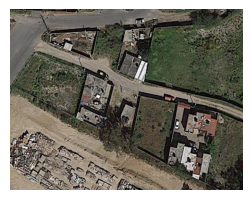

In [3]:
file_path = '/home/marcel/code/Zubairslb/city_sustainability/new_images/PUE3.tif'
fig = plt.figure(figsize=(3, 3))
image = Image.open(file_path)
plt.axis('off')
plt.imshow(image)
plt.show()
#To get the shape is necessary to convert to numpy and get shape Uncoment following lines
# image = np.array(image)
# image.shape

In [4]:
resize_im = image_resize(256,256,image)
resize_im.size

(256, 256)

In [5]:
resize_imnp = np.array(resize_im)
resize_imnp.shape

(256, 256, 3)

In [6]:
image_ok = np.expand_dims(resize_imnp, axis=0)
image_ok.shape

(1, 256, 256, 3)

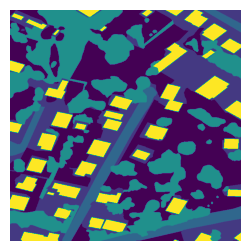

In [7]:
file_path = '../../raw_data/OpenEarthMap_wo_xBD/paris/labels/paris_2.tif'
fig = plt.figure(figsize=(3, 3))
label = Image.open(file_path)
plt.axis('off')
plt.imshow(label)
# plt.show()
# label = np.array(label)
# label.shape

In [8]:
label.size

(650, 650)

In [9]:
path = '/home/marcel/code/Zubairslb/city_sustainability/model_training/marcel/20230525-03-unet_vgg16_0.50img_100epch_32btch_0.31iou_0.59acc/'

model_5 = tf.keras.models.load_model(path, custom_objects={"compute_iou": unet_model.compute_iou})

2023-05-26 17:42:11.617655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 17:42:11.619024: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Use the loaded model to make a prediction
label_pred = model_5.predict(image_ok)

1/1 [==============================] - 0s 196ms/step


In [11]:
label_pred.shape

(1, 256, 256, 9)

In [12]:
label_prednp = np.argmax(label_pred, axis=-1)

In [13]:
label_prednp.shape

(1, 256, 256)

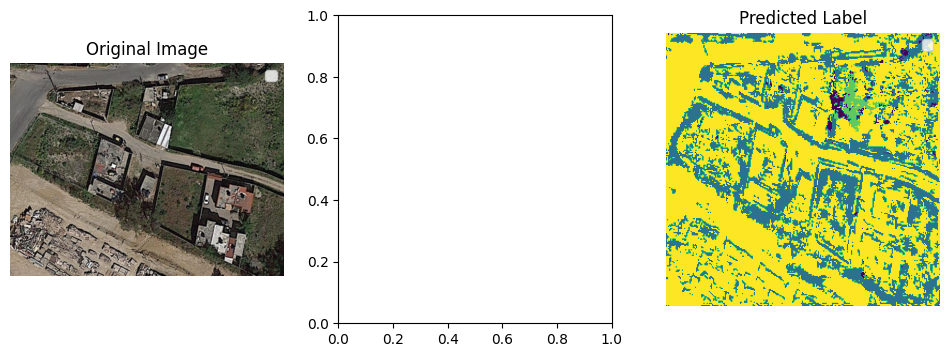

In [14]:
def display_images_side_by_side(image_array1, image_array2, image_array3, legend1, legend2, legend3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
     
    # Display the first image with legend
    axs[0].imshow(image_array1)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[0].legend([legend1])
    
#     # Display the second image with legend
#     axs[1].imshow(image_array2)
#     axs[1].set_title('Actual Label')
#     axs[1].axis('off')
#     axs[1].legend([legend2])
    
    # Display the third image with legend
    # Reshape the image_array1 to remove the extra dimension
    image_array3 = np.squeeze(image_array3)
    
    axs[2].imshow(image_array3)
    axs[2].set_title('Predicted Label')
    axs[2].axis('off')
    axs[2].legend([legend3])
    
    plt.show()

# Call the function with the correct arguments
display_images_side_by_side(image, label, label_prednp, 'X_test_scaled', 'y_test_np', 'y_pred_np')

In [29]:
def color_plot(image):
    # Define the class colors
    class_colors = ['#000000', '#800000', '#00FF24', '#949494', '#FFFFFF', '#226126', '#0045FF', '#4BB549', '#DE1F07']
    # Create a colormap with the class colors
    cmap = sns.color_palette(class_colors, as_cmap=True)
    # Set the minimum and maximum values for the color mapping
    vmin = 0  # Minimum value
    vmax = 8  # Maximum value
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Create a masked array to ignore NaN values in the image
    masked_image = np.ma.masked_invalid(image_array)
    # Create a heatmap of the data using the custom colormap
    sns.heatmap(masked_image, cmap=cmap, vmin=vmin, vmax=vmax)
    # Show the plot
    plt.show()

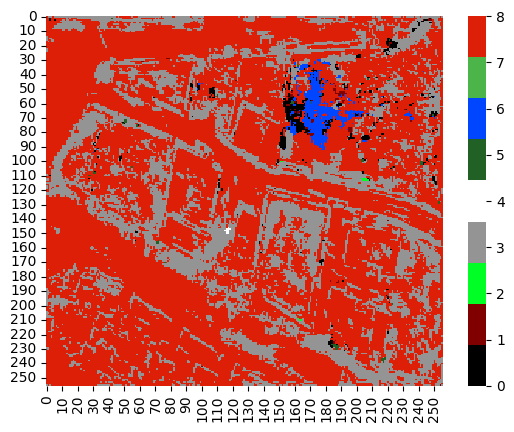

In [16]:
label_color = np.squeeze(label_prednp)
color_plot(label_color)

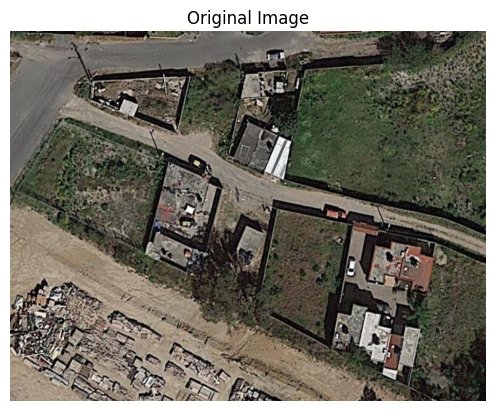

In [17]:
numpy_array_image = image
# Create subplots with a single row and single column
fig, axs = plt.subplots(1, 1)
# Display the image
axs.imshow(numpy_array_image)
axs.set_title('Original Image')
axs.axis('off')
# Show the plot
plt.show()

In [20]:
y_pred_ar.shape

(256, 256)

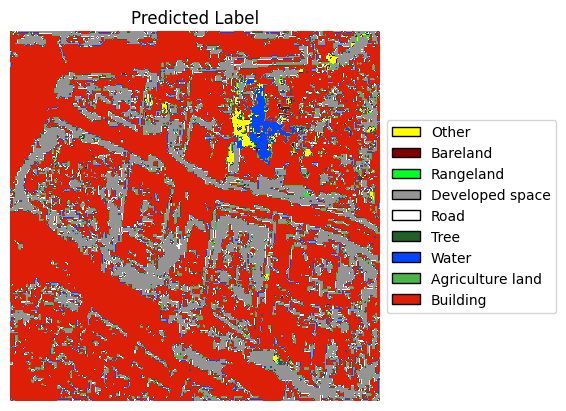

In [31]:
class_colors = {
    "Other": '#FFFF00',   # Class 0 - Yellow
    "Bareland": '#800000',   # Class 1 - Maroon
    "Rangeland": '#00FF24',   # Class 2 - Lime Green
    "Developed space": '#949494',   # Class 3 - Grey
    "Road": '#FFFFFF',   # Class 4 - White
    "Tree": '#226126',   # Class 5 - Forest Green
    "Water": '#0045FF',   # Class 6 - Blue
    "Agriculture land": '#4BB549',   # Class 7 - Dark Green
    "Building": '#DE1F07'   # Class 8 - Red
}


# Assuming you have a numpy array y_pred_np and colormap cmap defined
y_pred_ar = np.squeeze(label_prednp)

# Create a single plot
fig, ax = plt.subplots()

# Create a color map using the class_colors dictionary
cmap = plt.cm.colors.ListedColormap(list(class_colors.values()))

# Plot the image with the color map
im = ax.imshow(y_pred_ar, cmap=cmap)
ax.set_title('Predicted Label')
ax.axis('off')

# Create a custom legend using the class_colors dictionary
legend_elements = [mpatches.Patch(facecolor=color, edgecolor='black', label=class_label)
                   for class_label, color in class_colors.items()]

# Add the legend outside the plot
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()